# __Import and Setup__

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers, optimizers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2, ResNet50
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import os

# __Data Preperation__

In [2]:
base_dir = './data/GTSRB'

train_df = pd.read_csv(os.path.join(base_dir, 'Train.csv'))
test_df = pd.read_csv(os.path.join(base_dir, 'Test.csv'))
meta_df = pd.read_csv(os.path.join(base_dir, 'Meta.csv'))

print("Training Data Sample:")
print(train_df.head())

Training Data Sample:
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png  


In [3]:
base_dir = './data/GTSRB'

# Debugging abs path
print(f"Absolute base directory path: {os.path.abspath(base_dir)}")

# Verifying directories and sample image
sample_path = train_df['Path'].iloc[0]
full_sample_path = os.path.join(base_dir, sample_path)
print(f"\nVerifying sample image path:")
print(f"Sample path from CSV: {sample_path}")
print(f"Full sample path: {full_sample_path}")
print(f"Path exists: {os.path.exists(full_sample_path)}")

# Listing contents of base dir
print("\nContents of base directory:")
if os.path.exists(base_dir):
    print(os.listdir(base_dir))
else:
    print(f"Base directory {base_dir} does not exist!")

# Checking if able to access first 5 images
print("\nChecking first 5 images:")
for _, row in train_df.head().iterrows():
    full_path = os.path.join(base_dir, row['Path'])
    print(f"Path: {full_path}")
    print(f"Exists: {os.path.exists(full_path)}")

Absolute base directory path: c:\Users\zaina\OneDrive\Desktop\tsic\data\GTSRB

Verifying sample image path:
Sample path from CSV: Train/20/00020_00000_00000.png
Full sample path: ./data/GTSRB\Train/20/00020_00000_00000.png
Path exists: True

Contents of base directory:
['Meta', 'Meta.csv', 'Test', 'Test.csv', 'Train', 'Train.csv']

Checking first 5 images:
Path: ./data/GTSRB\Train/20/00020_00000_00000.png
Exists: True
Path: ./data/GTSRB\Train/20/00020_00000_00001.png
Exists: True
Path: ./data/GTSRB\Train/20/00020_00000_00002.png
Exists: True
Path: ./data/GTSRB\Train/20/00020_00000_00003.png
Exists: True
Path: ./data/GTSRB\Train/20/00020_00000_00004.png
Exists: True


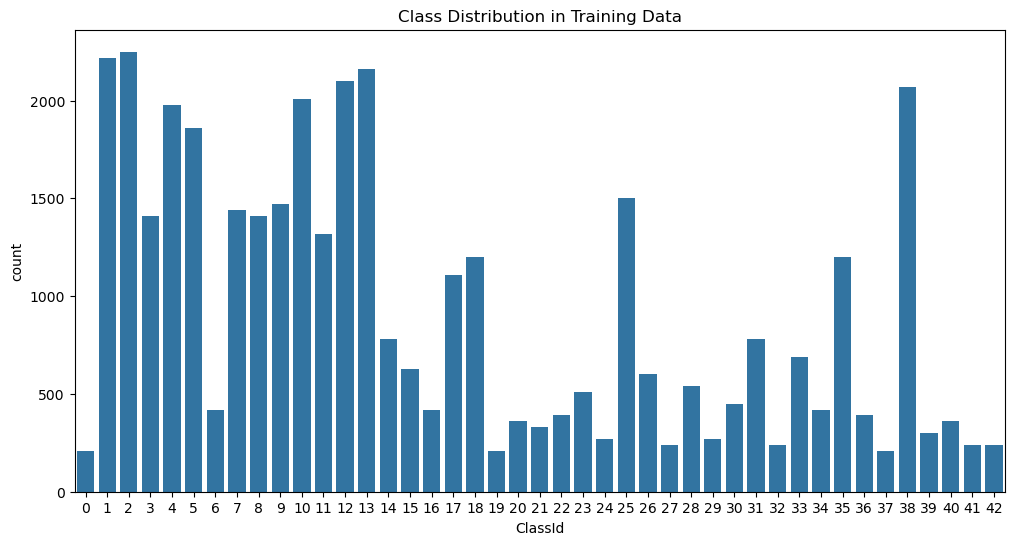

In [4]:
plt.figure(figsize=(12, 6))
sns.countplot(x='ClassId', data=train_df)
plt.title('Class Distribution in Training Data')
plt.show()

## Data Preprocessing, Load-Split, & Encoding

In [5]:
def load_images_in_batches(df, base_dir, batch_size=1000):
    images = []
    labels = []
    failed_images = []
    
    print(f"Starting to load {len(df)} images...")
    
    for i in range(0, len(df), batch_size):
        batch_df = df.iloc[i:i + batch_size]
        batch_images = []
        batch_labels = []
        
        for _, row in batch_df.iterrows():
            image_path = os.path.join(base_dir, row['Path'])
            try:
                img = tf.keras.preprocessing.image.load_img(
                    image_path, 
                    target_size=(64, 64),
                    color_mode='rgb'
                )
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                img_array = img_array / 255.0
                
                batch_images.append(img_array)
                batch_labels.append(row['ClassId'])
            except Exception as e:
                print(f"Error loading {image_path}: {str(e)}")
                failed_images.append(image_path)
                
        images.extend(batch_images)
        labels.extend(batch_labels)
        print(f"Loaded {len(images)} images so far...")
    
    if failed_images:
        print(f"Failed to load {len(failed_images)} images")
        
    return np.array(images), np.array(labels), failed_images



In [6]:
# Split
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Load
print("Loading training data...")
X_train, y_train, failed_train = load_images_in_batches(train_df, base_dir)
print("\nLoading validation data...")
X_val, y_val, failed_val = load_images_in_batches(val_df, base_dir)

# Load test 
print("\nLoading test data...")
X_test, y_test, failed_test = load_images_in_batches(test_df, base_dir)

print("\nDataset Information:")
print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"\nNumber of classes: {len(np.unique(y_train))}")
print(f"\nFailed images summary:")
print(f"Training: {len(failed_train)} images")
print(f"Validation: {len(failed_val)} images")
print(f"Test: {len(failed_test)} images")

Loading training data...
Starting to load 31367 images...
Loaded 1000 images so far...
Loaded 2000 images so far...
Loaded 3000 images so far...
Loaded 4000 images so far...
Loaded 5000 images so far...
Loaded 6000 images so far...
Loaded 7000 images so far...
Loaded 8000 images so far...
Loaded 9000 images so far...
Loaded 10000 images so far...
Loaded 11000 images so far...
Loaded 12000 images so far...
Loaded 13000 images so far...
Loaded 14000 images so far...
Loaded 15000 images so far...
Loaded 16000 images so far...
Loaded 17000 images so far...
Loaded 18000 images so far...
Loaded 19000 images so far...
Loaded 20000 images so far...
Loaded 21000 images so far...
Loaded 22000 images so far...
Loaded 23000 images so far...
Loaded 24000 images so far...
Loaded 25000 images so far...
Loaded 26000 images so far...
Loaded 27000 images so far...
Loaded 28000 images so far...
Loaded 29000 images so far...
Loaded 30000 images so far...
Loaded 31000 images so far...
Loaded 31367 images s

In [8]:
print("Training set class distribution:") 
print(train_df['ClassId'].value_counts(normalize=True))

print("\nValidation set class distribution:") 
print(val_df['ClassId'].value_counts(normalize=True))

print("\nTest set class distribution:") 
print(test_df['ClassId'].value_counts(normalize=True))

Training set class distribution:
ClassId
2     0.057321
1     0.055664
13    0.054803
10    0.052954
38    0.052667
12    0.052476
4     0.049734
5     0.048714
25    0.038321
9     0.037173
7     0.037109
8     0.035929
3     0.035547
11    0.034367
35    0.031116
18    0.030669
17    0.028023
31    0.019766
14    0.019543
33    0.017566
15    0.016036
26    0.015239
28    0.014059
23    0.012784
16    0.011318
30    0.011318
6     0.010776
34    0.010584
36    0.009883
22    0.009692
40    0.009564
20    0.008990
21    0.008512
39    0.007715
29    0.006727
24    0.006727
42    0.006344
32    0.006344
41    0.006153
27    0.006153
0     0.005292
37    0.005197
19    0.005133
Name: proportion, dtype: float64

Validation set class distribution:
ClassId
1     0.060444
12    0.057893
2     0.057638
13    0.056236
4     0.053558
38    0.053303
10    0.044504
5     0.042336
9     0.038766
25    0.038001
3     0.037618
8     0.036088
7     0.035195
11    0.030859
18    0.030349
17    0.0294

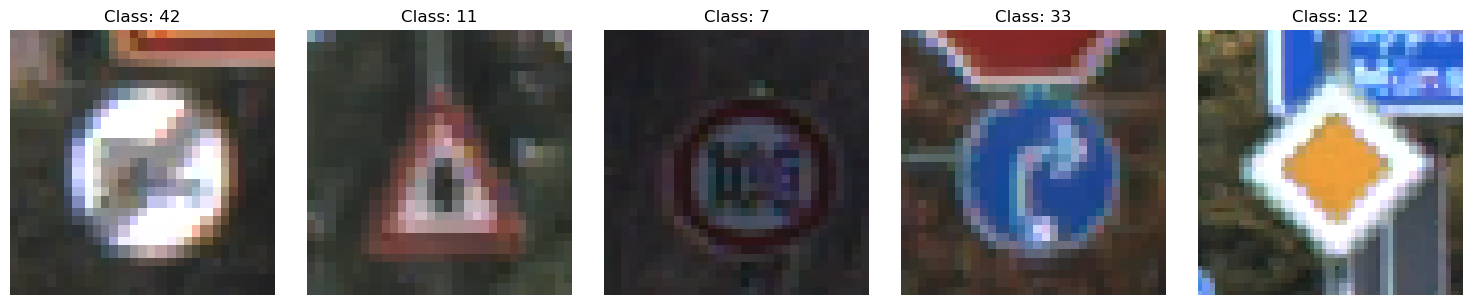

In [9]:
plt.figure(figsize=(15, 3))
for i in range(5):
    idx = np.random.randint(0, len(X_train))
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train[idx])
    plt.title(f'Class: {y_train[idx]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## One-Hot Encoding

In [10]:
print("Converting labels to one-hot encoding...")
num_classes = len(np.unique(y_train))
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_encoded = tf.keras.utils.to_categorical(y_val, num_classes)
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes)

print(f"One-hot encoded shapes:")
print(f"Training labels: {y_train_encoded.shape}")
print(f"Validation labels: {y_val_encoded.shape}")
print(f"Test labels: {y_test_encoded.shape}")

Converting labels to one-hot encoding...
One-hot encoded shapes:
Training labels: (31367, 43)
Validation labels: (7842, 43)
Test labels: (12630, 43)


In [11]:
os.makedirs('./data', exist_ok=True)
np.save('./data/X_train.npy', X_train)
np.save('./data/y_train.npy', y_train_encoded)

In [12]:
np.save('./data/X_test.npy', X_test)
np.save('./data/y_test.npy', y_test_encoded)

## Data Augmentation

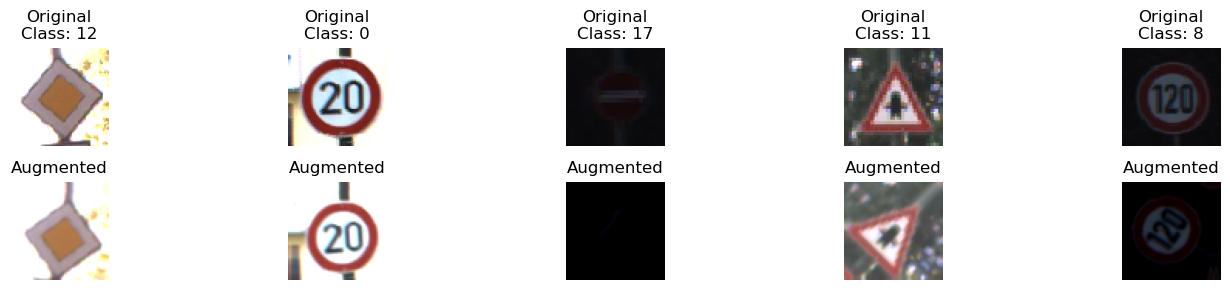

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.Rescaling(1./255)
])

plt.figure(figsize=(15, 3))
for i in range(5):
    idx = np.random.randint(0, len(X_train))
    image = X_train[idx]
    
    # Original image
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.title(f'Original\nClass: {np.argmax(y_train_encoded[idx])}')
    plt.axis('off')
    
    # Augmented image
    augmented = data_augmentation(tf.cast(image * 255, tf.float32))
    plt.subplot(2, 5, i+6)
    plt.imshow(augmented)
    plt.title('Augmented')
    plt.axis('off')

plt.tight_layout()
plt.show()

# __Model Development & Training__

## Custom CNN

In [14]:
def build_custom_cnn(input_shape=(64, 64, 3), num_classes=43):
    model = tf.keras.Sequential([
        # Input Layer
        tf.keras.layers.Input(shape=input_shape),
        
        # Convolutional layers
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
        
        # Dense Layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

custom_cnn = build_custom_cnn()
custom_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
custom_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 31, 31, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 689,643 (2.63 MB)

 Trainable params: 689,195 (2.63 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Creating datasets with proper repeat
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Training dataset with augmentation
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_encoded))
train_dataset = (
    train_dataset
    .shuffle(1000)
    .map(lambda x, y: (data_augmentation(tf.cast(x * 255, tf.float32)), y), 
         num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(AUTOTUNE)
)

val_dataset = (tf.data.Dataset.from_tensor_slices((X_val, y_val_encoded))
               .batch(BATCH_SIZE)
               .repeat()
               .prefetch(AUTOTUNE))



# Calculate steps per epoch
steps_per_epoch = len(X_train) // BATCH_SIZE
validation_steps = len(X_val) // BATCH_SIZE


In [16]:
print("Training Custom CNN...")
custom_history = custom_cnn.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint('./models/custom_cnn_best.keras', 
                                         save_best_only=True),
    ]
)

Training Custom CNN...
Epoch 1/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 30s 28ms/step - accuracy: 0.2219 - loss: 3.2863 - val_accuracy: 0.6199 - val_loss: 1.1975
Epoch 2/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 29s 30ms/step - accuracy: 0.4902 - loss: 1.6232 - val_accuracy: 0.8254 - val_loss: 0.5492
Epoch 3/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 29s 30ms/step - accuracy: 0.6225 - loss: 1.1726 - val_accuracy: 0.8575 - val_loss: 0.4496
Epoch 4/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - accuracy: 0.7149 - loss: 0.8856 - val_accuracy: 0.8853 - val_loss: 0.3191
Epoch 5/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 28s 29ms/step - accuracy: 0.7637 - loss: 0.7291 - val_accuracy: 0.9434 - val_loss: 0.1837
Epoch 6/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 28s 29ms/step - accuracy: 0.7987 - loss: 0.6274 - val_accuracy: 0.9369 - val_loss: 0.2231
Epoch 7/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - accuracy: 0.8258 - loss: 0.5521 - val_accuracy: 0.9619 - val_loss: 0.1230
Epoch 8/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 29s 30ms/step - accuracy: 0

In [17]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_encoded)).batch(BATCH_SIZE)
custom_cnn = tf.keras.models.load_model('./models/custom_cnn_best.keras')
test_loss, test_accuracy = custom_cnn.evaluate(X_test, y_test_encoded, verbose=1)
print(f'\nCustom CNN Test Results:')
print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test loss: {test_loss:.4f}')

395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9471 - loss: 0.2032

Custom CNN Test Results:
Test accuracy: 0.9472
Test loss: 0.2105


## MobileNetV2

In [ ]:
def build_mobilenetv2(input_shape=(64, 64, 3), num_classes=43):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        pooling='avg',
        weights='imagenet'
    )
    for layer in base_model.layers[:-20]:
        layer.trainable = False
    
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Dense(128, 
                            activation='relu',
                            kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.7),  # Increase dropout
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

mobilenetv2_model = build_mobilenetv2()
mobilenetv2_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
mobilenetv2_model.summary()

C:\Users\zaina\AppData\Local\Temp\ipykernel_13108\12488435.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,427,499 (9.26 MB)

 Trainable params: 1,221,995 (4.66 MB)

 Non-trainable params: 1,205,504 (4.60 MB)

In [ ]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# MobileNetV2 preprocessing
train_dataset_mobilenet = tf.data.Dataset.from_tensor_slices((X_train, y_train_encoded))
train_dataset_mobilenet = (
    train_dataset_mobilenet
    .shuffle(1000)
    .map(lambda x, y: (data_augmentation(tf.cast(x * 255, tf.float32)), y), 
         num_parallel_calls=AUTOTUNE)
    .map(lambda x, y: ((x * 2) - 1, y),  # Scaling augmented images to [-1,1]
         num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(AUTOTUNE)
)

# Validation dataset preprocesing for MobileNetV2
val_dataset_mobilenet = tf.data.Dataset.from_tensor_slices((X_val, y_val_encoded))
val_dataset_mobilenet = (
    val_dataset_mobilenet
    .map(lambda x, y: ((tf.cast(x, tf.float32) * 2) - 1, y))  # scaling to [-1,1]
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(AUTOTUNE)
)

steps_per_epoch = len(X_train) // BATCH_SIZE
validation_steps = len(X_val) // BATCH_SIZE

for images, labels in train_dataset_mobilenet.take(1):
    print("\nTraining data:")
    print(f"Image value range: [{tf.reduce_min(images)}, {tf.reduce_max(images)}]")
    print(f"Image shape: {images.shape}")


Training data:
Image value range: [-1.0, 1.0]
Image shape: (32, 64, 64, 3)


In [26]:
# Before preprocessing, raw image
print("Using NumPy:")
print("X_test min:", np.min(X_test))
print("X_test max:", np.max(X_test))

print("\nUsing TensorFlow:")
print("X_test min:", tf.reduce_min(X_test).numpy())
print("X_test max:", tf.reduce_max(X_test).numpy())


Using NumPy:
X_test min: 0.0
X_test max: 1.0

Using TensorFlow:
X_test min: 0.0
X_test max: 1.0


In [ ]:
# Creating test dataset with MobileNetV2 preprocessing
test_dataset_mobilenet = tf.data.Dataset.from_tensor_slices((X_test, y_test_encoded))
test_dataset_mobilenet = (
    test_dataset_mobilenet
    .map(lambda x, y: ((tf.cast(x, tf.float32) * 2) - 1, y))  # Scale to [-1,1]
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# Inspect one batch to verify scaling to [-1, 1]
for images, labels in test_dataset_mobilenet.take(1):
    print("After preprocessing (MobileNetV2):")
    print("Min value:", tf.reduce_min(images).numpy())
    print("Max value:", tf.reduce_max(images).numpy())


After preprocessing (MobileNetV2):
Min value: -1.0
Max value: 1.0


In [28]:
# After preprocessing
print("1. Raw data ranges (should be [0,1]):")
print("X_test:", np.min(X_test), "to", np.max(X_test))

train_batch = next(iter(train_dataset_mobilenet))
val_batch = next(iter(val_dataset_mobilenet))
test_batch = next(iter(test_dataset_mobilenet))

print("\n2. After preprocessing (should be [-1,1]):")
print("Training data:", tf.reduce_min(train_batch[0]).numpy(), "to", tf.reduce_max(train_batch[0]).numpy())
print("Validation data:", tf.reduce_min(val_batch[0]).numpy(), "to", tf.reduce_max(val_batch[0]).numpy())
print("Test data:", tf.reduce_min(test_batch[0]).numpy(), "to", tf.reduce_max(test_batch[0]).numpy())

1. Raw data ranges (should be [0,1]):
X_test: 0.0 to 1.0

2. After preprocessing (should be [-1,1]):
Training data: -1.0 to 1.0
Validation data: -1.0 to 1.0
Test data: -1.0 to 1.0


In [ ]:
steps_per_epoch = len(X_train) // BATCH_SIZE
validation_steps = len(X_val) // BATCH_SIZE

print("Training MobileNetV2...")
mobilenetv2_history = mobilenetv2_model.fit(
    train_dataset_mobilenet,
    validation_data=val_dataset_mobilenet,
    epochs=30,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            filepath='models/mobilenetv2_best.keras',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=0
        )
    ],
    # verbose=1
)

Training MobileNetV2...
Epoch 1/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 77s 73ms/step - accuracy: 0.1187 - loss: 5.9347 - val_accuracy: 0.3814 - val_loss: 3.8767
Epoch 2/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 71s 72ms/step - accuracy: 0.3512 - loss: 3.9429 - val_accuracy: 0.4851 - val_loss: 2.8424
Epoch 3/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 70s 72ms/step - accuracy: 0.4285 - loss: 3.0417 - val_accuracy: 0.5366 - val_loss: 2.2704
Epoch 4/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 71s 73ms/step - accuracy: 0.4898 - loss: 2.4894 - val_accuracy: 0.5732 - val_loss: 1.9042
Epoch 5/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 71s 72ms/step - accuracy: 0.5262 - loss: 2.1338 - val_accuracy: 0.5811 - val_loss: 1.7404
Epoch 6/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 70s 71ms/step - accuracy: 0.5591 - loss: 1.8732 - val_accuracy: 0.5814 - val_loss: 1.6620
Epoch 7/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 71s 72ms/step - accuracy: 0.5813 - loss: 1.7128 - val_accuracy: 0.6013 - val_loss: 1.5277
Epoch 8/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 71s 73ms/step - accuracy: 

In [ ]:
print("Verifying preprocessing across datasets:")
for name, dataset in [("Train", train_dataset_mobilenet), ("Val", val_dataset_mobilenet), ("Test", test_dataset_mobilenet)]:
    for images, _ in dataset.take(1):
        print(f"{name} range: [{tf.reduce_min(images):.4f}, {tf.reduce_max(images):.4f}]")
        print(f"{name} shape: {images.shape}")


print("\nEvaluating MobileNetV2 with proper preprocessing:")
test_loss, test_accuracy = mobilenetv2_model.evaluate(
    test_dataset_mobilenet, 
    verbose=1
)
print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test loss: {test_loss:.4f}')

Verifying preprocessing across datasets:
Train range: [-1.0000, 1.0000]
Train shape: (32, 64, 64, 3)
Val range: [-1.0000, 1.0000]
Val shape: (32, 64, 64, 3)
Test range: [-1.0000, 1.0000]
Test shape: (32, 64, 64, 3)

Evaluating MobileNetV2 with proper preprocessing:
395/395 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.6170 - loss: 1.4159
Test accuracy: 0.6171
Test loss: 1.4153


## ResNet50

In [31]:
def build_resnet50(input_shape=(64, 64, 3), num_classes=43):
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Fine-tune the last 20 layers
    for layer in base_model.layers[:-20]:
        layer.trainable = False
    
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation='relu', 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

resnet_model = build_resnet50()
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

resnet_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2, 2, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,123,307 (92.02 MB)

 Trainable params: 9,466,923 (36.11 MB)

 Non-trainable params: 14,656,384 (55.91 MB)

In [32]:
for images, labels in train_dataset.take(1):
    print(f"Current image value range: [{tf.reduce_min(images)}, {tf.reduce_max(images)}]")
    print(f"Image shape: {images.shape}")

Current image value range: [0.0, 1.0]
Image shape: (32, 64, 64, 3)


In [ ]:
resnet_data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomContrast(0.2)
])

BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Applying augmentation, and finally apply ResNet50 preprocessing
train_dataset_resnet = tf.data.Dataset.from_tensor_slices((X_train, y_train_encoded))
train_dataset_resnet = (
    train_dataset_resnet
    .shuffle(1000)
    .map(lambda x, y: (resnet_data_augmentation(tf.cast(x * 255, tf.float32)), y),
         num_parallel_calls=AUTOTUNE)
    .map(lambda x, y: (tf.keras.applications.resnet50.preprocess_input(x), y),
         num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(AUTOTUNE)
)

# Converting [0,1] images to [0,255] then apply preprocess_input
val_dataset_resnet = tf.data.Dataset.from_tensor_slices((X_val, y_val_encoded))
val_dataset_resnet = (
    val_dataset_resnet
    .map(lambda x, y: (tf.keras.applications.resnet50.preprocess_input(tf.cast(x * 255, tf.float32)), y))
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(AUTOTUNE)
)

test_dataset_resnet = tf.data.Dataset.from_tensor_slices((X_test, y_test_encoded))
test_dataset_resnet = (
    test_dataset_resnet
    .map(lambda x, y: (tf.keras.applications.resnet50.preprocess_input(tf.cast(x * 255, tf.float32)), y))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# Verify preprocessing ranges across datasets
print("Verifying preprocessing across datasets:")
for name, dataset in [("Train", train_dataset_resnet), 
                      ("Val", val_dataset_resnet), 
                      ("Test", test_dataset_resnet)]:
    for images, _ in dataset.take(1):
        print(f"{name} range: [{tf.reduce_min(images):.4f}, {tf.reduce_max(images):.4f}]")
        print(f"{name} shape: {images.shape}")

Verifying preprocessing across datasets:
Train range: [-123.6800, 151.0610]
Train shape: (32, 64, 64, 3)
Val range: [-123.6800, 151.0610]
Val shape: (32, 64, 64, 3)
Test range: [-123.6800, 151.0610]
Test shape: (32, 64, 64, 3)


In [ ]:
steps_per_epoch = len(X_train) // BATCH_SIZE
validation_steps = len(X_val) // BATCH_SIZE

print("Training ResNet50...")
resnet50_history = resnet_model.fit(
    train_dataset_resnet,
    validation_data=val_dataset_resnet,
    epochs=30,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            filepath='models/resnet50_best.keras',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=0
        )
    ],
    verbose=1
)

Training ResNet50...
Epoch 1/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 196s 192ms/step - accuracy: 0.3076 - loss: 6.9419 - val_accuracy: 0.5955 - val_loss: 4.0702
Epoch 2/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 205s 209ms/step - accuracy: 0.5900 - loss: 3.7969 - val_accuracy: 0.7031 - val_loss: 2.5855
Epoch 3/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 201s 205ms/step - accuracy: 0.6801 - loss: 2.4975 - val_accuracy: 0.7462 - val_loss: 1.8060
Epoch 4/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 196s 200ms/step - accuracy: 0.7357 - loss: 1.7662 - val_accuracy: 0.7797 - val_loss: 1.3400
Epoch 5/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 196s 200ms/step - accuracy: 0.7714 - loss: 1.3284 - val_accuracy: 0.7911 - val_loss: 1.1213
Epoch 6/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 196s 200ms/step - accuracy: 0.7970 - loss: 1.0648 - val_accuracy: 0.8055 - val_loss: 0.9625
Epoch 7/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 195s 199ms/step - accuracy: 0.8116 - loss: 0.8982 - val_accuracy: 0.8233 - val_loss: 0.8078
Epoch 8/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 201s 205ms/step

In [ ]:
print(f'\nResNet50 Test Results:')
test_loss, test_accuracy = resnet_model.evaluate(
    test_dataset_resnet, 
    verbose=1
)
print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test loss: {test_loss:.4f}')

print("\nVerifying preprocessing across datasets:")
for name, dataset in [("Train", train_dataset), ("Val", val_dataset), ("Test", test_dataset_resnet)]:
    for images, _ in dataset.take(1):
        print(f"{name} range: [{tf.reduce_min(images):.4f}, {tf.reduce_max(images):.4f}]")
        print(f"{name} shape: {images.shape}")


ResNet50 Test Results:
395/395 ━━━━━━━━━━━━━━━━━━━━ 34s 84ms/step - accuracy: 0.6647 - loss: 1.4296
Test accuracy: 0.6631
Test loss: 1.4446

Verifying preprocessing across datasets:
Train range: [0.0000, 1.0000]
Train shape: (32, 64, 64, 3)
Val range: [0.0000, 1.0000]
Val shape: (32, 64, 64, 3)
Test range: [-123.6800, 151.0610]
Test shape: (32, 64, 64, 3)


In [36]:
histories = {
    'custom_cnn': custom_history,
    'mobilenetv2': mobilenetv2_history,
    'resnet50': resnet50_history
}


In [37]:
import json
# Save training histories
for name, history in histories.items():
    with open(f'./histories/{name}_history.json', 'w') as f:
        json.dump(history.history, f)

In [38]:
import os
import json

# Path where histories are saved
history_dir = './histories'
model_names = ['custom_cnn', 'mobilenetv2', 'resnet50']

# Dictionary to store loaded histories
histories = {}

for name in model_names:
    history_path = os.path.join(history_dir, f'{name}_history.json')
    if os.path.exists(history_path):
        with open(history_path, 'r') as f:
            history_data = json.load(f)
            # Simulate a History object by wrapping in a class-like object
            class HistoryWrapper:
                def __init__(self, history):
                    self.history = history
            histories[name] = HistoryWrapper(history_data)
    else:
        print(f"[Warning] History file for '{name}' not found.")


# __Model Evaluation__

## Accuracy & Loss Plots

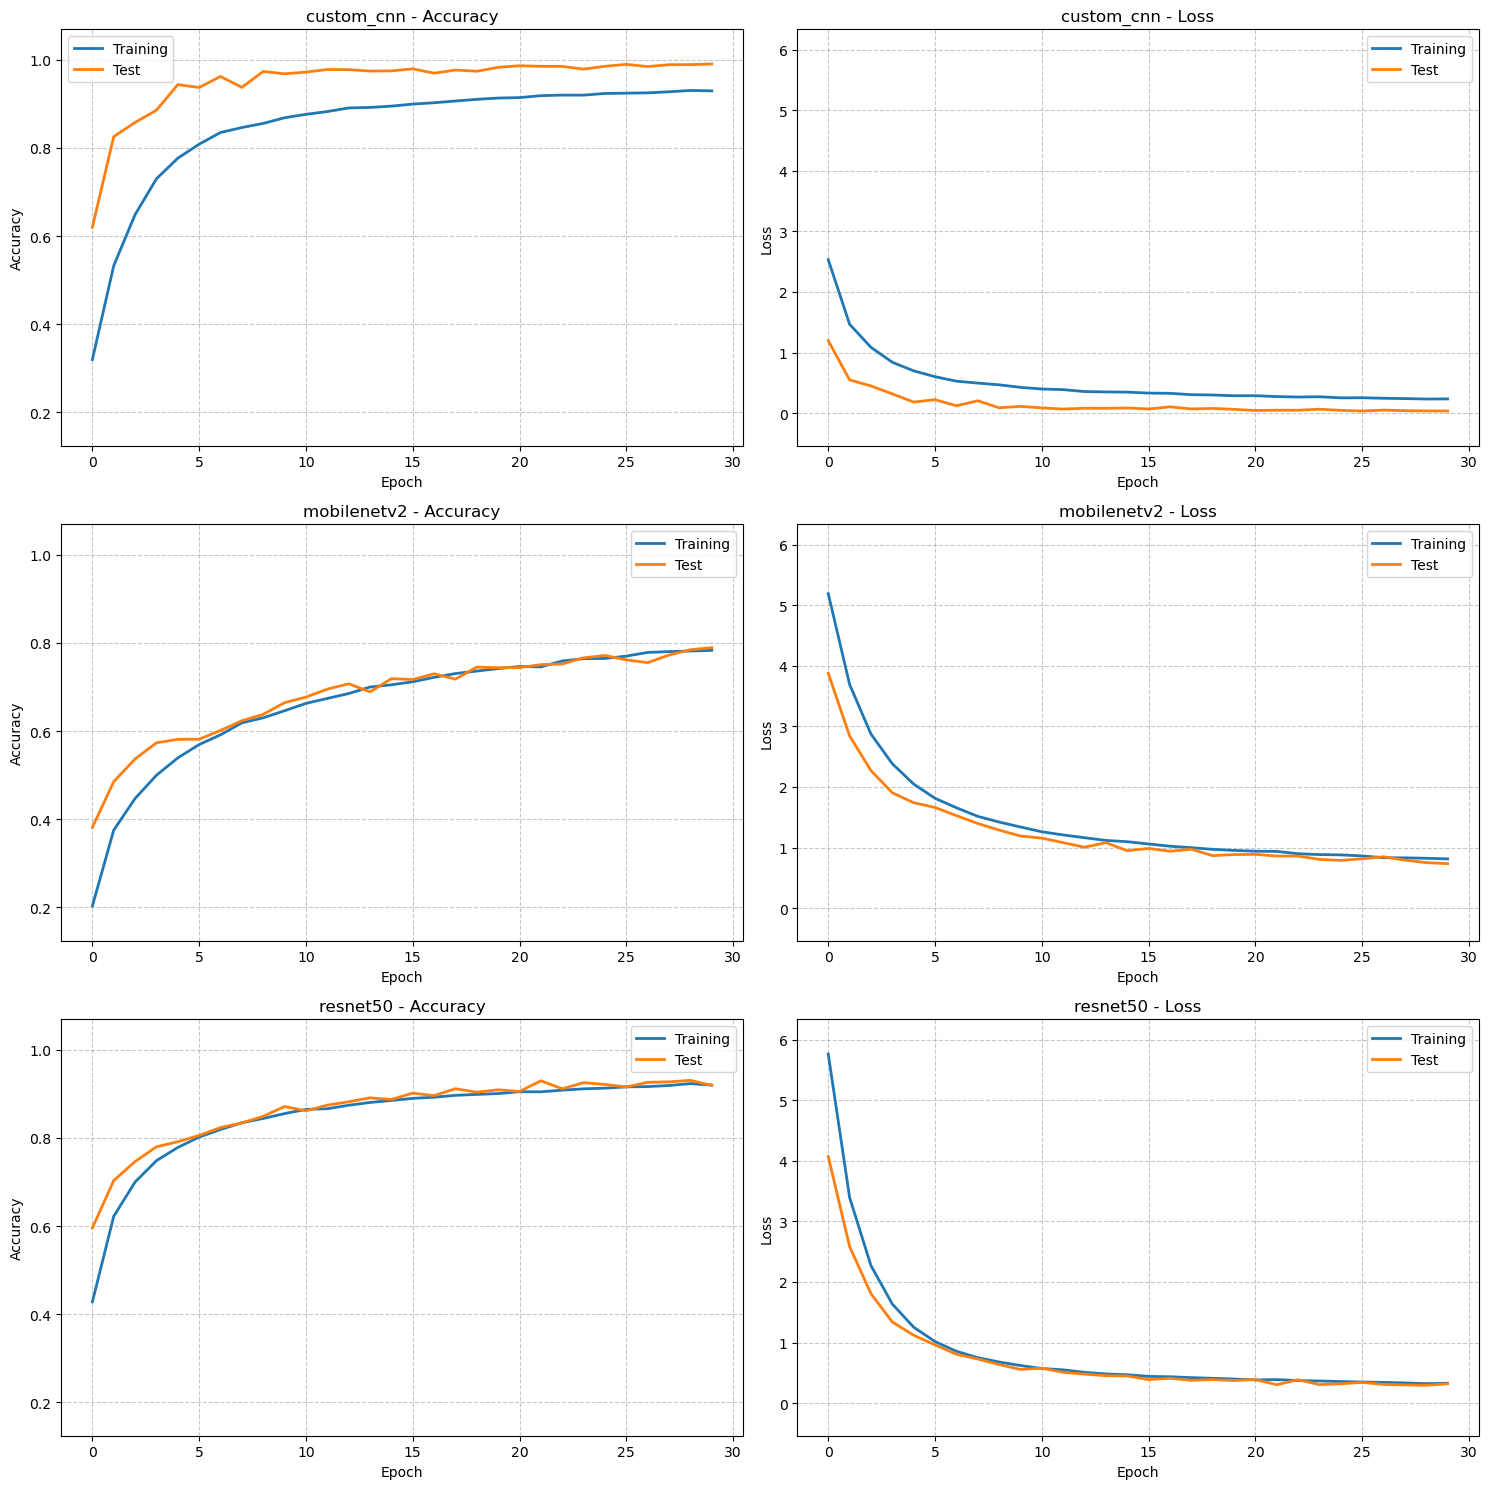


Final Metrics:
--------------------------------------------------

custom_cnn:
Final Training Accuracy: 0.9292
Final Training Loss: 0.2357
Final Test Accuracy: 0.9901
Final Test Loss: 0.0364

mobilenetv2:
Final Training Accuracy: 0.7829
Final Training Loss: 0.8138
Final Test Accuracy: 0.7890
Final Test Loss: 0.7352

resnet50:
Final Training Accuracy: 0.9196
Final Training Loss: 0.3305
Final Test Accuracy: 0.9190
Final Test Loss: 0.3214


In [ ]:
# Plotting test accuracy and loss for each model in separate rows with standardized axes"""
def plot_model_comparisons(histories, model_names):
    if not histories:
        print("Error: Empty histories")
        return
        
    n_models = len(model_names)
    plt.figure(figsize=(15, 5 * n_models))
    
    # Finding global min/max values for standardization
    acc_min, acc_max = float('inf'), float('-inf')
    loss_min, loss_max = float('inf'), float('-inf')
    
    # Getting min/max values across all models
    for name in model_names:
        if name in histories:
            history = histories[name]
            metrics = history.history if hasattr(history, 'history') else history
            
            # Accuracy bounds
            acc_values = metrics['accuracy']
            acc_min = min(acc_min, min(acc_values))
            acc_max = max(acc_max, max(acc_values))
            if 'val_accuracy' in metrics:
                val_acc = metrics['val_accuracy']
                acc_min = min(acc_min, min(val_acc))
                acc_max = max(acc_max, max(val_acc))
                
            # Loss bounds
            loss_values = metrics['loss']
            loss_min = min(loss_min, min(loss_values))
            loss_max = max(loss_max, max(loss_values))
            if 'val_loss' in metrics:
                val_loss = metrics['val_loss']
                loss_min = min(loss_min, min(val_loss))
                loss_max = max(loss_max, max(val_loss))
    
    # Adding padding to axes ranges
    acc_range = acc_max - acc_min
    loss_range = loss_max - loss_min
    acc_min -= acc_range * 0.1
    acc_max += acc_range * 0.1
    loss_min -= loss_range * 0.1
    loss_max += loss_range * 0.1
    
    for idx, name in enumerate(model_names, 1):
        if name in histories:
            history = histories[name]
            
            # Accuracy subplot
            plt.subplot(n_models, 2, 2*idx-1)
            if isinstance(history, dict):
                plt.plot(history['accuracy'], label='Training', linewidth=2)
                if 'val_accuracy' in history:
                    plt.plot(history['val_accuracy'], label='Test', linewidth=2)
            elif hasattr(history, 'history'):
                plt.plot(history.history['accuracy'], label='Training', linewidth=2)
                if 'val_accuracy' in history.history:
                    plt.plot(history.history['val_accuracy'], label='Test', linewidth=2)
                    
            plt.title(f'{name} - Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.legend()
            plt.ylim(acc_min, acc_max)  # Standardised y-axis for accuracy
            
            # Loss subplot
            plt.subplot(n_models, 2, 2*idx)
            if isinstance(history, dict):
                plt.plot(history['loss'], label='Training', linewidth=2)
                if 'val_loss' in history:
                    plt.plot(history['val_loss'], label='Test', linewidth=2)
            elif hasattr(history, 'history'):
                plt.plot(history.history['loss'], label='Training', linewidth=2)
                if 'val_loss' in history.history:
                    plt.plot(history.history['val_loss'], label='Test', linewidth=2)
                    
            plt.title(f'{name} - Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.legend()
            plt.ylim(loss_min, loss_max)  # Standardised y-axis for loss

    plt.tight_layout()
    plt.show()

    print("\nFinal Metrics:")
    print("-" * 50)
    for name in model_names:
        if name in histories:
            history = histories[name]
            if isinstance(history, dict):
                metrics = history
            else:
                metrics = history.history
                
            print(f"\n{name}:")
            print(f"Final Training Accuracy: {metrics['accuracy'][-1]:.4f}")
            print(f"Final Training Loss: {metrics['loss'][-1]:.4f}")
            if 'val_accuracy' in metrics:
                print(f"Final Test Accuracy: {metrics['val_accuracy'][-1]:.4f}")
            if 'val_loss' in metrics:
                print(f"Final Test Loss: {metrics['val_loss'][-1]:.4f}")

plot_model_comparisons(histories, model_names)

# __Model Analysis__

In [ ]:
# Data distributions
print("\nData Distribution Check:")
print(f"Train shape: {X_train.shape}")
print(f"Val shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")
print(f"\nTrain range: [{X_train.min():.4f}, {X_train.max():.4f}]")
print(f"Val range: [{X_val.min():.4f}, {X_val.max():.4f}]")
print(f"Test range: [{X_test.min():.4f}, {X_test.max():.4f}]")

# Class distributions
from collections import Counter
print("\nClass Distribution:")
print("Train:", Counter(np.argmax(y_train_encoded, axis=1)))
print("Val:", Counter(np.argmax(y_val_encoded, axis=1)))
print("Test:", Counter(np.argmax(y_test_encoded, axis=1)))


Data Distribution Check:
Train shape: (31367, 64, 64, 3)
Val shape: (7842, 64, 64, 3)
Test shape: (12630, 64, 64, 3)

Train range: [0.0000, 1.0000]
Val range: [0.0000, 1.0000]
Test range: [0.0000, 1.0000]

Class Distribution:
Train: Counter({2: 1798, 1: 1746, 13: 1719, 10: 1661, 38: 1652, 12: 1646, 4: 1560, 5: 1528, 25: 1202, 9: 1166, 7: 1164, 8: 1127, 3: 1115, 11: 1078, 35: 976, 18: 962, 17: 879, 31: 620, 14: 613, 33: 551, 15: 503, 26: 478, 28: 441, 23: 401, 30: 355, 16: 355, 6: 338, 34: 332, 36: 310, 22: 304, 40: 300, 20: 282, 21: 267, 39: 242, 29: 211, 24: 211, 42: 199, 32: 199, 41: 193, 27: 193, 0: 166, 37: 163, 19: 161})
Val: Counter({1: 474, 12: 454, 2: 452, 13: 441, 4: 420, 38: 418, 10: 349, 5: 332, 9: 304, 25: 298, 3: 295, 8: 283, 7: 276, 11: 242, 18: 238, 17: 231, 35: 224, 14: 167, 31: 160, 33: 138, 15: 127, 26: 122, 23: 109, 28: 99, 30: 95, 34: 88, 22: 86, 6: 82, 36: 80, 20: 78, 16: 65, 21: 63, 40: 60, 24: 59, 29: 59, 39: 58, 19: 49, 27: 47, 37: 47, 41: 47, 0: 44, 42: 41, 32

In [ ]:
# Load saved models
custom_cnn = tf.keras.models.load_model('./models/custom_cnn_best.keras')
mobilenetv2_model = tf.keras.models.load_model('./models/mobilenetv2_best.keras')
resnet_model = tf.keras.models.load_model('./models/resnet50_best.keras')

In [42]:
SIGN_CLASSES = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)',
    2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)',
    5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)',
    7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)',
    9: 'No passing',
    10: 'No passing for vehicles over 3.5 metric tons',
    11: 'Right-of-way at the next intersection',
    12: 'Priority road',
    13: 'Yield',
    14: 'Stop',
    15: 'No vehicles',
    16: 'Vehicles over 3.5 metric tons prohibited',
    17: 'No entry',
    18: 'General caution',
    19: 'Dangerous curve to the left',
    20: 'Dangerous curve to the right',
    21: 'Double curve',
    22: 'Bumpy road',
    23: 'Slippery road',
    24: 'Road narrows on the right',
    25: 'Road work',
    26: 'Traffic signals',
    27: 'Pedestrians',
    28: 'Children crossing',
    29: 'Bicycles crossing',
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing',
    32: 'End of all speed and passing limits',
    33: 'Turn right ahead',
    34: 'Turn left ahead',
    35: 'Ahead only',
    36: 'Go straight or right',
    37: 'Go straight or left',
    38: 'Keep right',
    39: 'Keep left',
    40: 'Roundabout mandatory',
    41: 'End of no passing',
    42: 'End of no passing by vehicles over 3.5 metric tons'
}

In [43]:
os.makedirs('./data', exist_ok=True)

np.save('./data/y_test_encoded.npy', y_test_encoded)

print(f"Test labels saved successfully with shape: {y_test_encoded.shape}")

Test labels saved successfully with shape: (12630, 43)


In [ ]:
def generate_classification_reports(models, X_test, y_test_encoded):
    reports = {}
    y_test_classes = np.argmax(y_test_encoded, axis=1)
    
    for name, model in models.items():
        print(f"\nGenerating classification report for {name}...")
        
        # Applying appropriate preprocessing based on model type
        if name == 'custom_cnn':
            X_processed = X_test.copy()
        elif name == 'mobilenetv2':
            X_processed = X_test * 2.0 - 1.0  # Scale to [-1, 1]
        elif name == 'resnet50':
            X_processed = tf.keras.applications.resnet50.preprocess_input(X_test * 255.0)
        
        # Generating predictions
        y_pred = model.predict(X_processed)
        y_pred_classes = np.argmax(y_pred, axis=1)
        
        report = classification_report(
            y_test_classes,
            y_pred_classes,
            target_names=[SIGN_CLASSES[i] for i in range(43)],
            output_dict=False
        )
        
        print(f"\nClassification Report for {name}:")
        print(report)
        
        reports[name] = report
    
    return reports

classification_reports = generate_classification_reports(
    {'custom_cnn': custom_cnn, 
     'mobilenetv2': mobilenetv2_model,
     'resnet50': resnet_model},
    X_test,
    y_test_encoded
)


Generating classification report for custom_cnn...
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step

Classification Report for custom_cnn:
                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       1.00      0.63      0.78        60
                              Speed limit (30km/h)       0.87      1.00      0.93       720
                              Speed limit (50km/h)       0.96      0.94      0.95       750
                              Speed limit (60km/h)       0.99      0.86      0.92       450
                              Speed limit (70km/h)       0.97      0.93      0.95       660
                              Speed limit (80km/h)       0.89      0.96      0.92       630
                       End of speed limit (80km/h)       0.99      0.96      0.97       150
                             Speed limit (100km/h)       0.93      0.95      0.94       450
                             Speed limi


Generating confusion matrix for custom_cnn...
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step

Generating confusion matrix for mobilenetv2...
395/395 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step

Generating confusion matrix for resnet50...
395/395 ━━━━━━━━━━━━━━━━━━━━ 32s 81ms/step


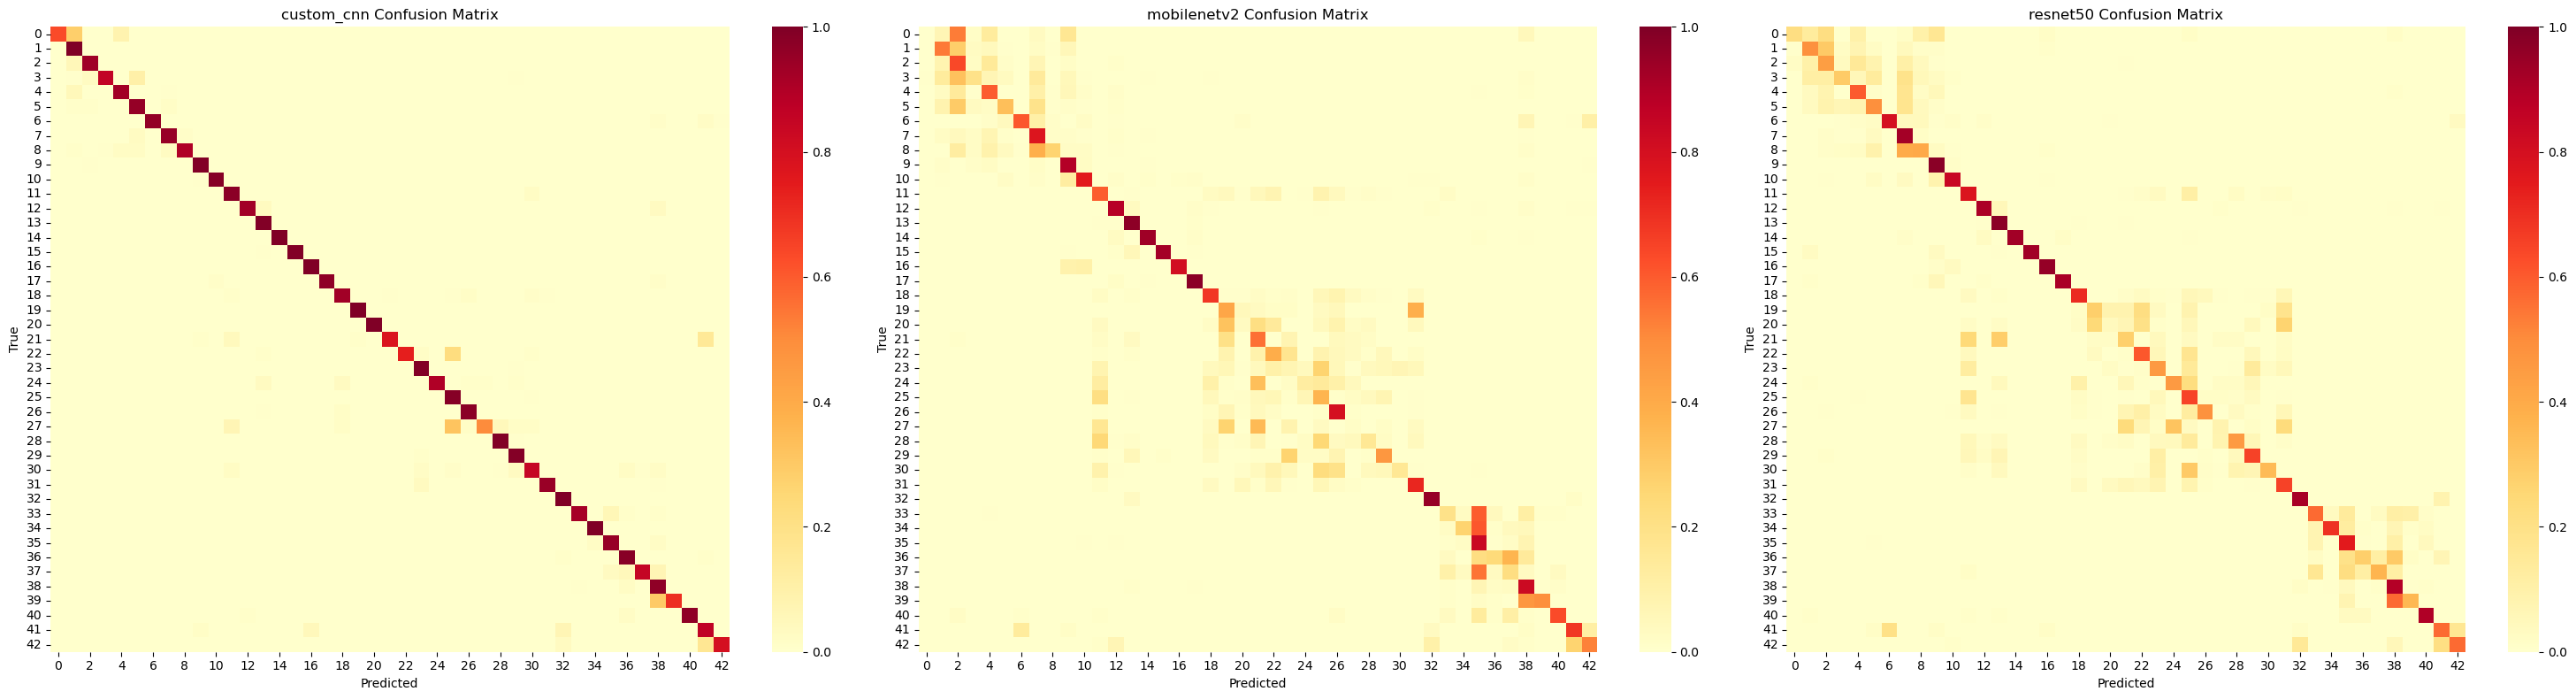

In [ ]:
def plot_confusion_matrices(models, X_test, y_test_encoded):
    y_test_classes = np.argmax(y_test_encoded, axis=1)
    
    fig, axes = plt.subplots(1, 3, figsize=(30, 8))
    
    for idx, (name, model) in enumerate(models.items()):
        print(f"\nGenerating confusion matrix for {name}...")
        
        if name == 'custom_cnn':
            X_processed = X_test.copy()
        elif name == 'mobilenetv2':
            X_processed = X_test * 2.0 - 1.0
        elif name == 'resnet50':
            X_processed = tf.keras.applications.resnet50.preprocess_input(X_test * 255.0)
        
        y_pred = model.predict(X_processed)
        y_pred_classes = np.argmax(y_pred, axis=1)
        
        cm = confusion_matrix(y_test_classes, y_pred_classes)
        
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        sns.heatmap(cm_normalized, ax=axes[idx], cmap='YlOrRd', 
                   vmin=0, vmax=1, annot=False)
        
        axes[idx].set_title(f'{name} Confusion Matrix')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('True')
        
    plt.tight_layout()
    plt.show()
    
    return fig

confusion_matrices = plot_confusion_matrices(
    {'custom_cnn': custom_cnn, 
     'mobilenetv2': mobilenetv2_model,
     'resnet50': resnet_model},
    X_test,
    y_test_encoded
)

confusion_matrices.savefig('./confusion_matrices.png', 
                         dpi=300, 
                         bbox_inches='tight')

In [ ]:
# Verifying model configuration
print("Model input shape:", custom_cnn.input_shape)
print("Model output shape:", custom_cnn.output_shape)
print("\nTraining data properties:")
for images, labels in train_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)
    print("Image value range:", tf.reduce_min(images).numpy(), "to", tf.reduce_max(images).numpy())

Model input shape: (None, 64, 64, 3)
Model output shape: (None, 43)

Training data properties:
Image batch shape: (32, 64, 64, 3)
Labels batch shape: (32, 43)
Image value range: 0.0 to 1.0



Predicting custom images using best saved model...


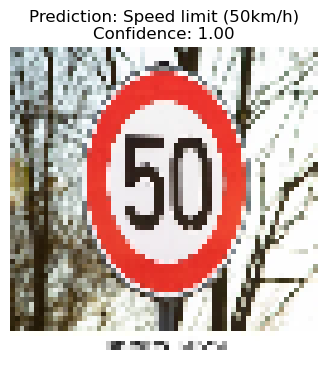


Image: 50speed.webp
Predicted Sign: Speed limit (50km/h)
Confidence: 1.00


In [ ]:
best_model = tf.keras.models.load_model('./models/custom_cnn_best.keras')


SIGN_CLASSES = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)',
    2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)',
    5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)',
    7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)',
    9: 'No passing',
    10: 'No passing for vehicles over 3.5 metric tons',
    11: 'Right-of-way at the next intersection',
    12: 'Priority road',
    13: 'Yield',
    14: 'Stop',
    15: 'No vehicles',
    16: 'Vehicles over 3.5 metric tons prohibited',
    17: 'No entry',
    18: 'General caution',
    19: 'Dangerous curve to the left',
    20: 'Dangerous curve to the right',
    21: 'Double curve',
    22: 'Bumpy road',
    23: 'Slippery road',
    24: 'Road narrows on the right',
    25: 'Road work',
    26: 'Traffic signals',
    27: 'Pedestrians',
    28: 'Children crossing',
    29: 'Bicycles crossing',
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing',
    32: 'End of all speed and passing limits',
    33: 'Turn right ahead',
    34: 'Turn left ahead',
    35: 'Ahead only',
    36: 'Go straight or right',
    37: 'Go straight or left',
    38: 'Keep right',
    39: 'Keep left',
    40: 'Roundabout mandatory',
    41: 'End of no passing',
    42: 'End of no passing by vehicles over 3.5 metric tons'
}

def predict_traffic_sign(image_path, model):
    img = tf.keras.preprocessing.image.load_img(
        image_path, 
        target_size=(64, 64),
        color_mode='rgb'
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, 0)
    
    # Make prediction using the best model
    predictions = model.predict(img_array, verbose=0)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])
    
    # Getting sign name from our dictionary
    sign_name = SIGN_CLASSES[predicted_class]
    
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 1, 1)
    plt.imshow(img)
    plt.title(f"Prediction: {sign_name}\nConfidence: {confidence:.2f}")
    plt.axis('off')
    plt.show()
    
    return sign_name, confidence

test_image = r'C:\Users\zaina\OneDrive\Desktop\50speed.webp',
    
print("\nPredicting custom images using best saved model...")
for image_path in test_image:
    sign_name, confidence = predict_traffic_sign(image_path, best_model)
    print(f"\nImage: {os.path.basename(image_path)}")
    print(f"Predicted Sign: {sign_name}")
    print(f"Confidence: {confidence:.2f}")